In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import geopandas as gpd

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [11]:
station_observations[station_observations['NAME'].str.contains('CRESTED')]

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES
176879,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,12/1/1963,0.0,",,0,",0.0,",,0,",0.0,",,0,"
176880,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,12/2/1963,0.0,",,0,",0.0,",,0,",0.0,",,0,"
176881,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,12/3/1963,0.0,",,0,",0.0,",,0,",0.0,",,0,"
176882,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,12/4/1963,0.0,",,0,",0.0,",,0,",0.0,",,0,"
176883,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,12/5/1963,0.0,",,0,",0.0,",,0,",0.0,",,0,"
...,...,...,...,...,...,...,...,...,...,...,...,...
198143,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,9/26/2022,0.0,",,7,0900",0.0,",,7,0900",0.0,",,7,0900"
198144,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,9/27/2022,0.0,",,7,0900",0.0,",,7,0900",0.0,",,7,0900"
198145,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,9/28/2022,0.0,",,7,0900",0.0,",,7,0900",0.0,",,7,0900"
198146,USC00051959,"CRESTED BUTTE, CO US",38.8738,-106.9772,2702.7,9/29/2022,0.0,",,7,0900",0.0,",,7,0900",0.0,",,7,0900"


In [2]:
# load in station_observations_UCRB.csv
station_observations = pd.read_csv('../data/precipdata/daily_ucrb_station_data.csv')
station_observations_filter = station_observations.set_index('DATE')[['STATION','NAME','PRCP', 'LONGITUDE', 'LATITUDE', 'ELEVATION']]
# convert LONGITUDE, LATITUDE, and ELEVATION to string
station_observations_filter['LONGITUDE'] = station_observations_filter['LONGITUDE'].astype(str)
station_observations_filter['LATITUDE'] = station_observations_filter['LATITUDE'].astype(str)
station_observations_filter['ELEVATION'] = station_observations_filter['ELEVATION'].astype(str)

# convert index to a datetime
station_observations_filter.index = pd.to_datetime(station_observations_filter.index, format='%m/%d/%Y')

# filter out data if PRCP is < 0 or greater than 250
station_observations_filter = station_observations_filter[(station_observations_filter['PRCP'] >= 0) & (station_observations_filter['PRCP'] <= 250)]
# create a function to group PRCP by the seasonal sum
def seasonal_sum(df):
    return df.groupby(pd.Grouper(freq='QS-OCT')).sum()

seasonal_sum_df = station_observations_filter.groupby('STATION').apply(seasonal_sum)
# reset the index and set level_1 to the index as a datetime
seasonal_sum_df.reset_index(inplace=True)

# set DATE to a datetime and make it the index
seasonal_sum_df['DATE'] = pd.to_datetime(seasonal_sum_df['DATE'], format='%m/%d/%Y')
seasonal_sum_df.set_index('DATE', inplace=True)
# add a column for water year (Oct - Sept) for each row 
seasonal_sum_df['WY'] = seasonal_sum_df.index.year.where(seasonal_sum_df.index.month < 10, seasonal_sum_df.index.year + 1)

# remove data where the STATION is USC00055484
seasonal_sum_df = seasonal_sum_df[seasonal_sum_df['STATION'] != 'USC00055484']

/tmp/ipykernel_16224/3849844271.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(pd.Grouper(freq='QS-OCT')).sum()


In [3]:
# separate the data into seasonal dataframes for winter, spring, summer, and fall
winter_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([1])]
spring_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([4])]
summer_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([7])]
fall_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([10])]


# filter these new dataframes to values greater than 0 and less than 400, if zero fill with nan
winter_df['PRCP'] = winter_df['PRCP'].where((winter_df['PRCP'] > 0) & (winter_df['PRCP'] < 400), np.nan)
spring_df['PRCP'] = spring_df['PRCP'].where((spring_df['PRCP'] > 0) & (spring_df['PRCP'] < 400), np.nan)
summer_df['PRCP'] = summer_df['PRCP'].where((summer_df['PRCP'] > 0) & (summer_df['PRCP'] < 400), np.nan)
fall_df['PRCP'] = fall_df['PRCP'].where((fall_df['PRCP'] > 0) & (fall_df['PRCP'] < 400), np.nan)

# make WY the index
winter_df.set_index('WY', inplace=True)
spring_df.set_index('WY', inplace=True)
summer_df.set_index('WY', inplace=True)
fall_df.set_index('WY', inplace=True)

/tmp/ipykernel_16224/1066081072.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['PRCP'] = winter_df['PRCP'].where((winter_df['PRCP'] > 0) & (winter_df['PRCP'] < 400), np.nan)
/tmp/ipykernel_16224/1066081072.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring_df['PRCP'] = spring_df['PRCP'].where((spring_df['PRCP'] > 0) & (spring_df['PRCP'] < 400), np.nan)
/tmp/ipykernel_16224/1066081072.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

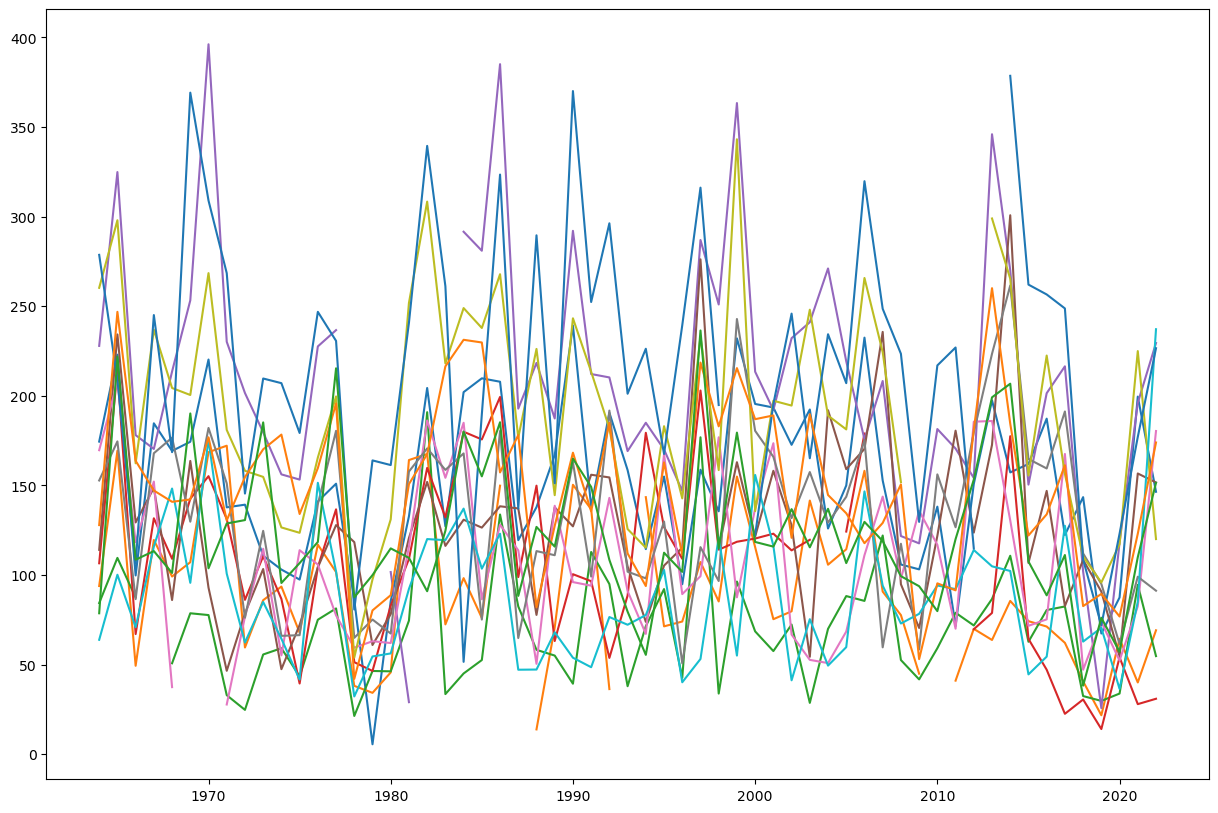

In [4]:
# create a plot of the spring data for each station on the same figure
fig, ax = plt.subplots(figsize=(15,10))
for station in summer_df['STATION'].unique():
    ax.plot(summer_df[summer_df['STATION'] == station].index, summer_df[summer_df['STATION'] == station]['PRCP'], label=station)

In [5]:
# calculate the sum for each WY for each station
annual_sum_df = seasonal_sum_df.groupby(['STATION', 'WY']).sum()
annual_sum_df.reset_index(inplace=True)
# make WY the new index
annual_sum_df.set_index('WY', inplace=True)
# replace values equal to 0 with nan
annual_sum_df['PRCP'] = annual_sum_df['PRCP'].where(annual_sum_df['PRCP'] > 0, np.nan)

In [6]:
# create a hypothesis test to see if pre-2000 and post-2000 are PRCP values for spring df are different
# create a function to perform the hypothesis test
def hypothesis_test(df, year, alternative='greater'):
    # create a dataframe for pre-2000 and post-2000
    pre_2000 = df.loc[:year-1]
    if len(pre_2000) < 20:
        return np.nan
    post_2000 = df.loc[year:]
    # perform a t-test on the two dataframes
    t_test = stats.ttest_ind(pre_2000['PRCP'], post_2000['PRCP'], equal_var=False, alternative=alternative, nan_policy='omit')
    # return the p-value
    return t_test.pvalue

# create a function to calculate the percent difference in mean values between the two periods
def percent_difference(df, year):
    # create a dataframe for pre-2000 and post-2000
    pre_2000 = df.loc[:year-1]
    if len(pre_2000) < 20:
        return np.nan
    post_2000 = df.loc[year:]
    # calculate the mean for each period
    pre_2000_mean = pre_2000['PRCP'].mean()
    post_2000_mean = post_2000['PRCP'].mean()
    # calculate the percent difference
    percent_diff = (post_2000_mean - pre_2000_mean) / pre_2000_mean * 100
    # return the percent difference
    return percent_diff

In [14]:
# iterate through the independent sites and run the hypothesis test with year = 2000
annual_significant_change = {}
annual_no_significant_change = {}
for station in annual_sum_df['STATION'].unique():
    result = hypothesis_test(annual_sum_df[annual_sum_df['STATION'] == station], 2000, alternative='greater')
    pct_diff = percent_difference(annual_sum_df[annual_sum_df['STATION'] == station], 2000)
    if result <= 0.11:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        annual_significant_change[station] = pct_diff

    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        annual_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.1 | Significant Difference | -5.98 %
------------------
USC00053662 | 0.051 | Significant Difference | -14.27 %
------------------
USC00056832 | 0.225 | No Significant Difference | -5.15 %
------------------
USC00057618 | 0.0 | Significant Difference | -43.88 %
------------------
USC00057656 | 0.271 | No Significant Difference | -4.17 %
------------------
USC00057936 | 0.203 | No Significant Difference | -5.04 %
------------------
USC00058064 | 0.126 | No Significant Difference | -8.26 %
------------------
USC00058184 | 0.052 | Significant Difference | -9.97 %
------------------
USC00058204 | 0.0 | Significant Difference | -27.21 %
------------------
USC00058501 | 0.31 | No Significant Difference | -3.34 %
------------------
USC00058582 | 0.016 | Significant Difference | -13.11 %
------------------
USC00059175 | 0.01 | Significant Difference | -9.26 %
------------------
USC00059265 | 0.613 | No Significant Difference | 1.44 %
------------------


In [15]:
# iterate through the independent sites and run the hypothesis test with year = 2000
spring_significant_change = {}
spring_no_significant_change = {}
for station in spring_df['STATION'].unique():
    print(station)
    result = hypothesis_test(spring_df[spring_df['STATION'] == station], 2000, alternative='greater')
    pct_diff = percent_difference(spring_df[spring_df['STATION'] == station], 2000)
    if result < 0.1:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        spring_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        spring_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959
USC00051959 | 0.01 | Significant Difference | -18.03 %
------------------
USC00053662
USC00053662 | 0.071 | Significant Difference | -19.32 %
------------------
USC00056832
USC00056832 | 0.029 | Significant Difference | -21.56 %
------------------
USC00057618
USC00057618 | 0.0 | Significant Difference | -47.96 %
------------------
USC00057656
USC00057656 | 0.02 | Significant Difference | -23.34 %
------------------
USC00057936
USC00057936 | 0.366 | No Significant Difference | -3.57 %
------------------
USC00058064
USC00058064 | 0.194 | No Significant Difference | -8.85 %
------------------
USC00058184
USC00058184 | 0.095 | Significant Difference | -11.66 %
------------------
USC00058204
USC00058204 | 0.0 | Significant Difference | -40.19 %
------------------
USC00058501
USC00058501 | 0.151 | No Significant Difference | -10.58 %
------------------
USC00058582
USC00058582 | 0.068 | Significant Difference | -17.53 %
------------------
USC00059175
USC00059175 | 0.008 | Signific

In [17]:
# iterate through the independent sites and run the hypothesis test with year = 2000
summer_significant_change = {}
summer_no_significant_change = {}
for station in summer_df['STATION'].unique():
    
    result = hypothesis_test(summer_df[summer_df['STATION'] == station], 2000, alternative='greater')
    pct_diff = percent_difference(summer_df[summer_df['STATION'] == station], 2000)
    if result < 0.1:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        summer_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        summer_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.482 | No Significant Difference | -0.37 %
------------------
USC00053662 | 0.02 | Significant Difference | -22.28 %
------------------
USC00056832 | 0.346 | No Significant Difference | -4.68 %
------------------
USC00057618 | 0.011 | Significant Difference | -30.53 %
------------------
USC00057656 | 0.048 | Significant Difference | -14.95 %
------------------
USC00057936 | 0.893 | No Significant Difference | 14.91 %
------------------
USC00058064 | 0.455 | No Significant Difference | -1.34 %
------------------
USC00058184 | 0.85 | No Significant Difference | 10.98 %
------------------
USC00058204 | 0.311 | No Significant Difference | -4.37 %
------------------
USC00058501 | 0.716 | No Significant Difference | 7.53 %
------------------
USC00058582 | 0.179 | No Significant Difference | -8.47 %
------------------
USC00059175 | 0.093 | Significant Difference | -10.89 %
------------------
USC00059265 | 0.105 | No Significant Difference | -10.66 %
------------------


In [18]:
# iterate through the independent sites and run the hypothesis test with year = 2000
winter_significant_change = {}
winter_no_significant_change = {}
for station in winter_df['STATION'].unique():
    
    result = hypothesis_test(winter_df[winter_df['STATION'] == station], 2000, alternative='greater')
    pct_diff = percent_difference(winter_df[winter_df['STATION'] == station], 2000)
    if result < 0.05:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        winter_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        winter_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.464 | No Significant Difference | -1.02 %
------------------
USC00053662 | 0.202 | No Significant Difference | -13.28 %
------------------
USC00056832 | 0.747 | No Significant Difference | 8.0 %
------------------
USC00057618 | 0.0 | Significant Difference | -40.12 %
------------------
USC00057656 | 0.848 | No Significant Difference | 13.13 %
------------------
USC00057936 | 0.029 | Significant Difference | -15.58 %
------------------
USC00058064 | 0.117 | No Significant Difference | -14.47 %
------------------
USC00058184 | 0.003 | Significant Difference | -27.75 %
------------------
USC00058204 | 0.017 | Significant Difference | -21.8 %
------------------
USC00058501 | 0.148 | No Significant Difference | -13.69 %
------------------
USC00058582 | 0.211 | No Significant Difference | -10.91 %
------------------
USC00059175 | 0.198 | No Significant Difference | -6.42 %
------------------
USC00059265 | 0.921 | No Significant Difference | 12.47 %
------------------


In [19]:
# iterate through the independent sites and run the hypothesis test with year = 2000
fall_significant_change = {}
fall_no_significant_change = {}
for station in fall_df['STATION'].unique():
    
    result = hypothesis_test(fall_df[fall_df['STATION'] == station], 2000, alternative='greater')
    pct_diff = percent_difference(fall_df[fall_df['STATION'] == station], 2000)
    if result == np.nan:
        continue
    elif result < 0.05:
        print(station, '|', round(pct_diff,3), '|', 'Significant Difference')
        fall_significant_change[station] = pct_diff
    else:
        print(station, '|', round(pct_diff,3), '|', 'No Significant Difference')
        fall_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | -3.607 | No Significant Difference
------------------
USC00053662 | -9.111 | No Significant Difference
------------------
USC00056832 | 2.043 | No Significant Difference
------------------
USC00057618 | -39.157 | Significant Difference
------------------
USC00057656 | -3.086 | No Significant Difference
------------------
USC00057936 | -9.304 | No Significant Difference
------------------
USC00058064 | -22.2 | Significant Difference
------------------
USC00058184 | -12.605 | No Significant Difference
------------------
USC00058204 | -31.621 | Significant Difference
------------------
USC00058501 | -7.692 | No Significant Difference
------------------
USC00058582 | -12.603 | No Significant Difference
------------------
USC00059175 | -1.484 | No Significant Difference
------------------
USC00059265 | 4.611 | No Significant Difference
------------------


In [20]:
station_locs = station_observations_filter.drop_duplicates(subset='STATION')
# create a geodataframe of the station locations
station_locations = gpd.GeoDataFrame(station_locs, geometry=gpd.points_from_xy(station_locs['LONGITUDE'].astype(float), station_locs['LATITUDE'].astype(float)))
# set the coordinate reference system to WGS84
station_locations.crs = 'EPSG:4326'
# convert the coordinate reference system to UTM Zone 13N
station_locations = station_locations.to_crs('EPSG:32613')

ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# convert ucrb_boundary to UTM Zone 13N
ucrb_boundary = ucrb_boundary.to_crs('EPSG:32613')

# filter to only include locations inside the ucrb_boundary
station_locations = gpd.sjoin(station_locations, ucrb_boundary, how='inner', predicate='intersects')


In [21]:
import contextily as ctx

In [22]:
pd.Series(annual_significant_change).to_csv('../data/precipdata/station_changes_by_season/annual_significant_change.csv')
pd.Series(annual_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/annual_no_significant_change.csv')
# do the same for the seasonal changes
pd.Series(spring_significant_change).to_csv('../data/precipdata/station_changes_by_season/spring_significant_change.csv')
pd.Series(spring_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/spring_no_significant_change.csv')
pd.Series(summer_significant_change).to_csv('../data/precipdata/station_changes_by_season/summer_significant_change.csv')
pd.Series(summer_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/summer_no_significant_change.csv')
pd.Series(fall_significant_change).to_csv('../data/precipdata/station_changes_by_season/fall_significant_change.csv')
pd.Series(fall_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/fall_no_significant_change.csv')
pd.Series(winter_significant_change).to_csv('../data/precipdata/station_changes_by_season/winter_significant_change.csv')
pd.Series(winter_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/winter_no_significant_change.csv')

station_locations.to_file('../data/geodata/prcp_stations.json', driver='GeoJSON')

Text(0.5, 1.0, 'Annual Precipitation Change in the UCRB')

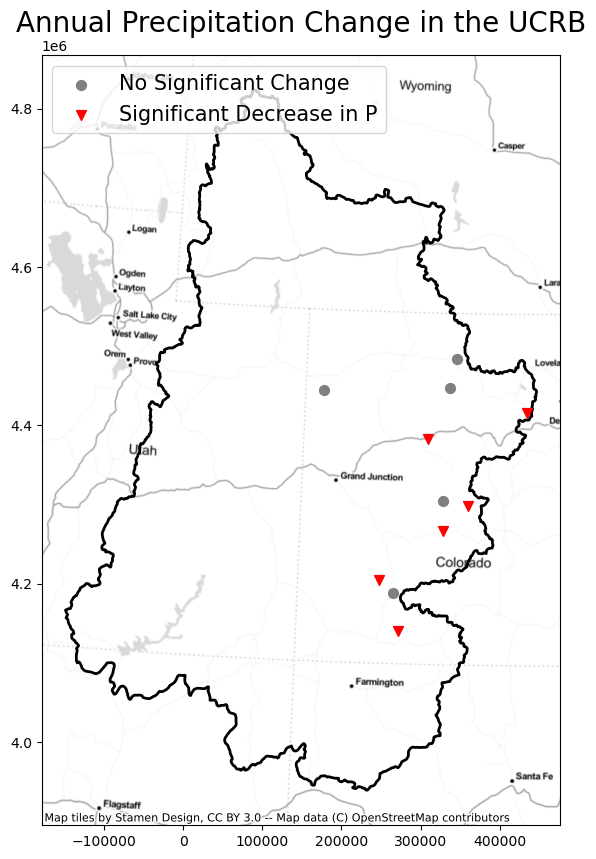

In [17]:
# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in annual_significant change with  marker size scaled by annual_significant_change value

station_locations[station_locations['STATION'].isin(annual_no_significant_change.keys())].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in annual_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(annual_significant_change.keys())].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.Stamen.TonerLite)

# add a legend for the station locations saying down arrow means significant decrease and circle means no significant change
ax.legend(['No Significant Change', 'Significant Decrease in P'], loc='upper left', fontsize=15)
ax.set_title('Annual Precipitation Change in the UCRB', fontsize=20)

In [280]:
# convert spring_no_significant_change.values() to array


array([26, 38, 32, 94, 34, 68, 50, 18])

Text(0.5, 1.0, 'Spring Precipitation Change in the UCRB')

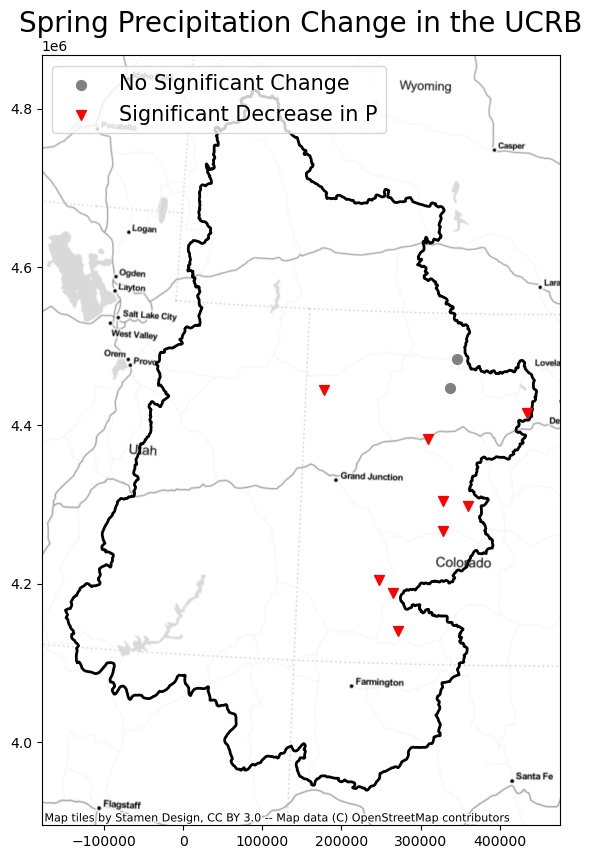

In [18]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in spring_significant change with  with a large circle
station_locations[station_locations['STATION'].isin(spring_no_significant_change.keys())].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in spring_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(spring_significant_change.keys())].plot(ax=ax, color='red', markersize=50, marker='v')
# add text to each point showing the percent difference
# for station in spring_significant_change.keys():
#     ax.text(station_locations[station_locations['STATION'] == station]['geometry'].x, station_locations[station_locations['STATION'] == station]['geometry'].y, str(round(spring_significant_change[station],0)) + '%', fontsize=15)
# add a basemap with the US states with Stamen Toner Topography
ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.Stamen.TonerLite)
# add a legend for the station locations saying down arrow means significant decrease and circle means no significant change
ax.legend(['No Significant Change', 'Significant Decrease in P'], loc='upper left', fontsize=15)
ax.set_title('Spring Precipitation Change in the UCRB', fontsize=20)

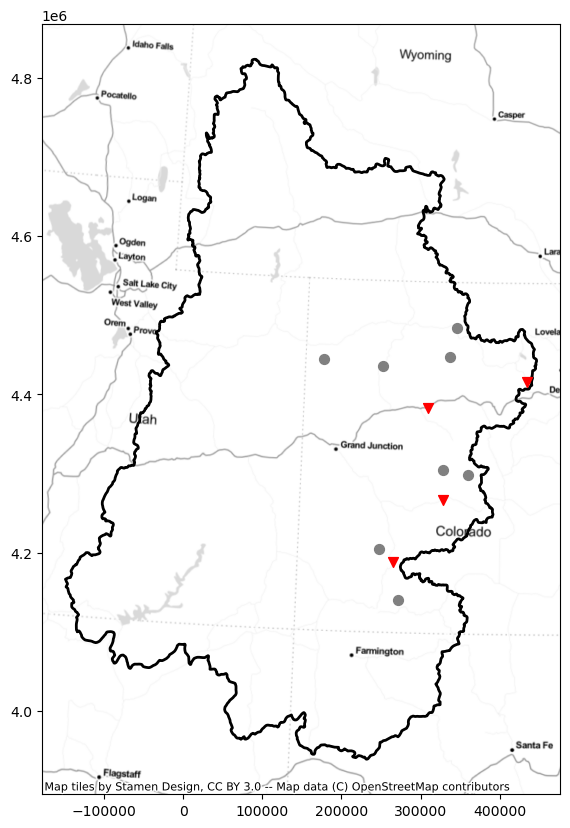

In [19]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in spring_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(summer_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in spring_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(summer_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states
ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.Stamen.TonerLite)

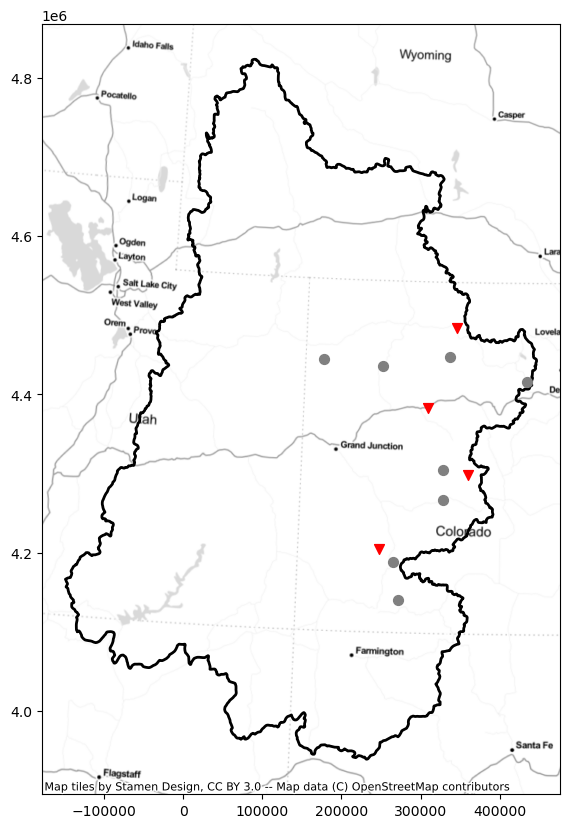

In [20]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in winter_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(winter_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in winter_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(winter_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.Stamen.TonerLite)

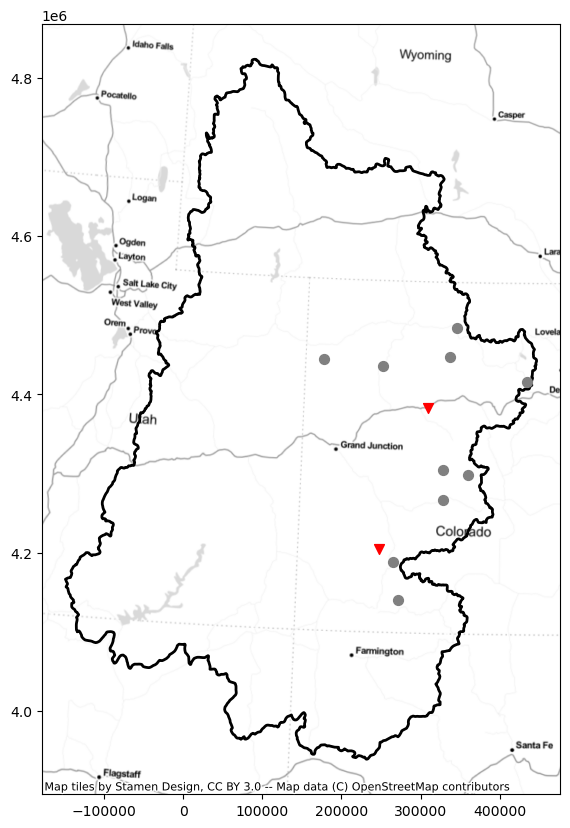

In [21]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in fall_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(fall_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in fall_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(fall_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.Stamen.TonerLite)